In [1]:
import numpy as np 
import pandas as pd 

import os

from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

In [2]:
from PIL import Image

data_folder = "broken"
PIC_DIR = f'dataset/'+data_folder+"/"

IMAGES_COUNT = 1000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).resize((128,128))
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\91997\AppData\Local\Temp\ipykernel_4732\2979124704.py:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
100%|██████████| 1000/1000 [00:01<00:00, 981.07it/s]


In [3]:
images = np.array(images) 
print(images.shape)

(1000, 128, 128, 3)


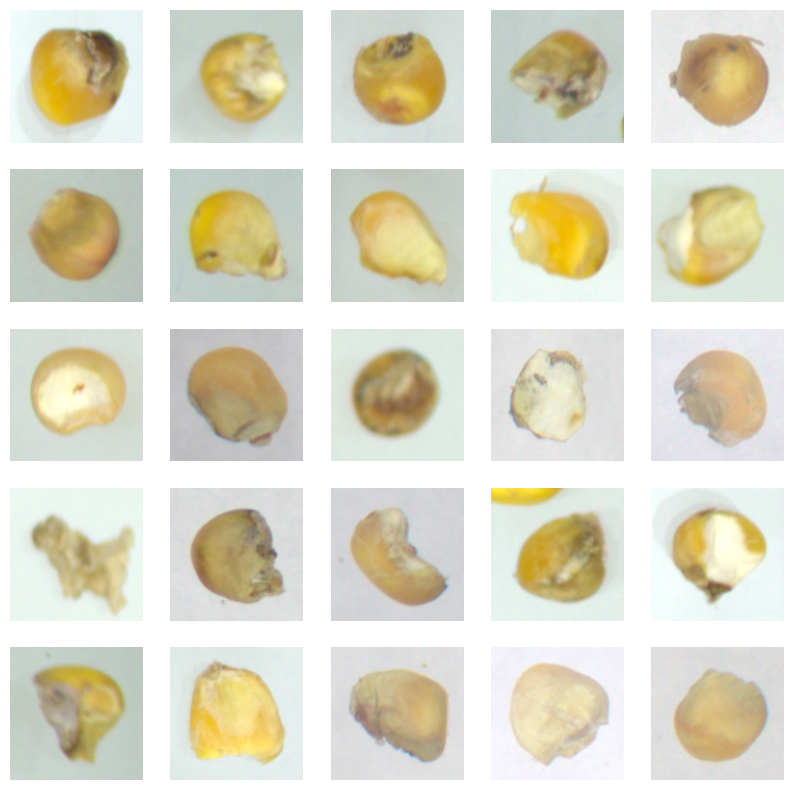

In [4]:

plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [5]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

In [6]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [7]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

In [8]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

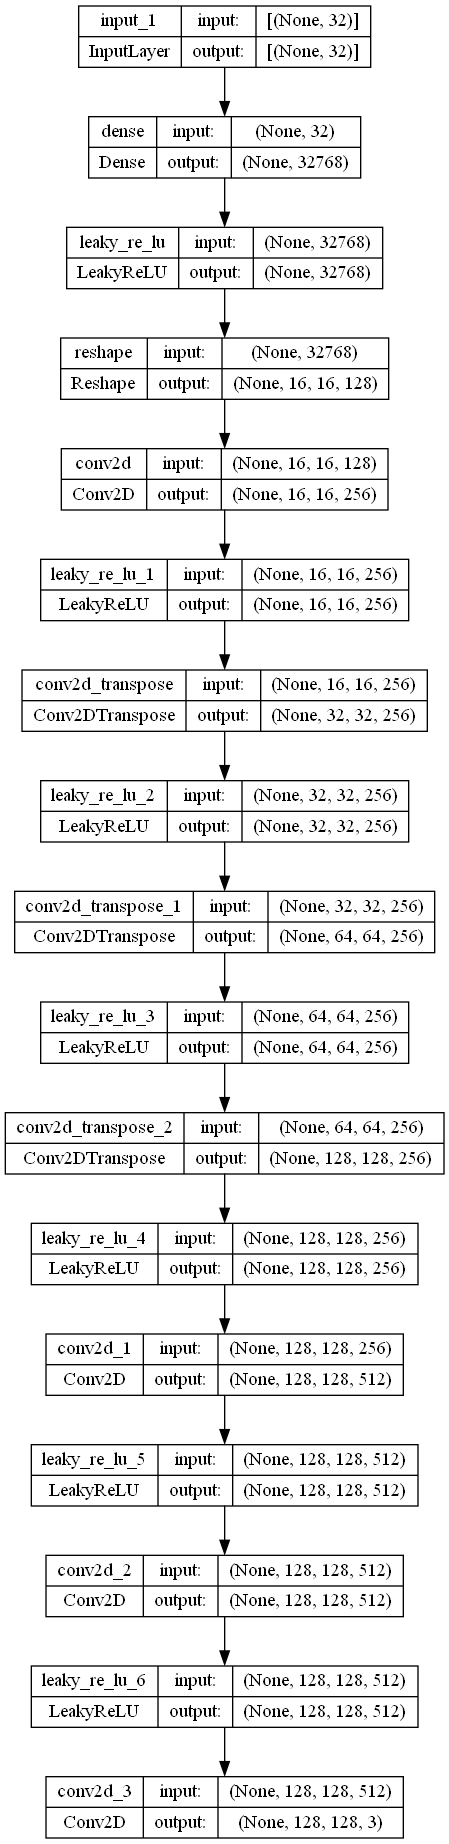

In [9]:
Image(model_to_dot(generator, show_shapes=True).create_png())

In [10]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0   

c:\Users\91997\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


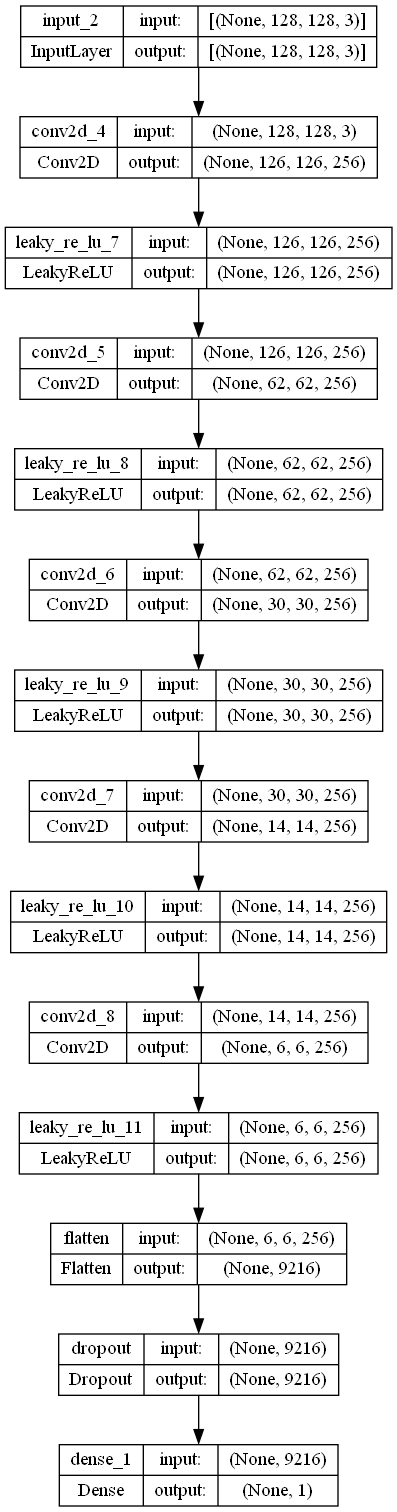

In [11]:
Image(model_to_dot(discriminator, show_shapes=True).create_png())

In [12]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [13]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [14]:
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 128, 128, 3)       14953987  
                                                                 
 model_1 (Functional)        (None, 1)                 4211713   
                                                                 
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


In [15]:
import time
from tqdm import tqdm

iters = 5000
batch_size = 8

RES_DIR = "generated_"+data_folder
FILE_PATH = '%s/generated_%d_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)


CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in tqdm(range(iters)):
    start_time = time.time()
    
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    
    generated = generator.predict(latent_vectors,verbose=0)
    

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if (step % 500 == 0) and (step > 0):
        gan.save_weights(f'gan_{data_folder}_{step}.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
            imarr = control_generated[i, :, :, :] * 255
            im = Img.fromarray(np.uint8(imarr))
            im.save(FILE_PATH % (RES_DIR, images_saved,i))

        
        images_saved += 1

 10%|█         | 500/5000 [14:05<1:37:35,  1.30s/it] 

501/5000: d_loss: 0.6919,  a_loss: 0.7303.  (1.4 sec)
2/2 [==============================] - 26s 3s/step


 20%|██        | 1000/5000 [25:21<1:26:41,  1.30s/it]

1001/5000: d_loss: 0.6948,  a_loss: 0.7530.  (1.4 sec)
2/2 [==============================] - 1s 1s/step


 30%|███       | 1500/5000 [36:05<1:14:17,  1.27s/it]

1501/5000: d_loss: 0.6929,  a_loss: 0.7401.  (1.4 sec)
2/2 [==============================] - 1s 1s/step


 40%|████      | 2000/5000 [46:52<1:03:24,  1.27s/it]

2001/5000: d_loss: 0.6962,  a_loss: 0.7434.  (1.4 sec)
2/2 [==============================] - 1s 1s/step


 50%|█████     | 2500/5000 [57:31<52:48,  1.27s/it]  

2501/5000: d_loss: 0.6915,  a_loss: 0.7628.  (1.4 sec)
2/2 [==============================] - 1s 1s/step


 60%|██████    | 3000/5000 [1:08:11<42:31,  1.28s/it]

3001/5000: d_loss: 0.6921,  a_loss: 0.7395.  (1.4 sec)
2/2 [==============================] - 1s 1s/step


 70%|███████   | 3500/5000 [1:18:51<31:54,  1.28s/it]

3501/5000: d_loss: 0.6974,  a_loss: 0.7359.  (1.4 sec)
2/2 [==============================] - 1s 1s/step


 80%|████████  | 4000/5000 [1:29:30<21:13,  1.27s/it]

4001/5000: d_loss: 0.6931,  a_loss: 0.7406.  (1.4 sec)
2/2 [==============================] - 1s 1s/step


 90%|█████████ | 4500/5000 [1:40:09<10:36,  1.27s/it]

4501/5000: d_loss: 0.6976,  a_loss: 0.7719.  (1.4 sec)
2/2 [==============================] - 1s 1s/step


100%|██████████| 5000/5000 [1:50:49<00:00,  1.33s/it]


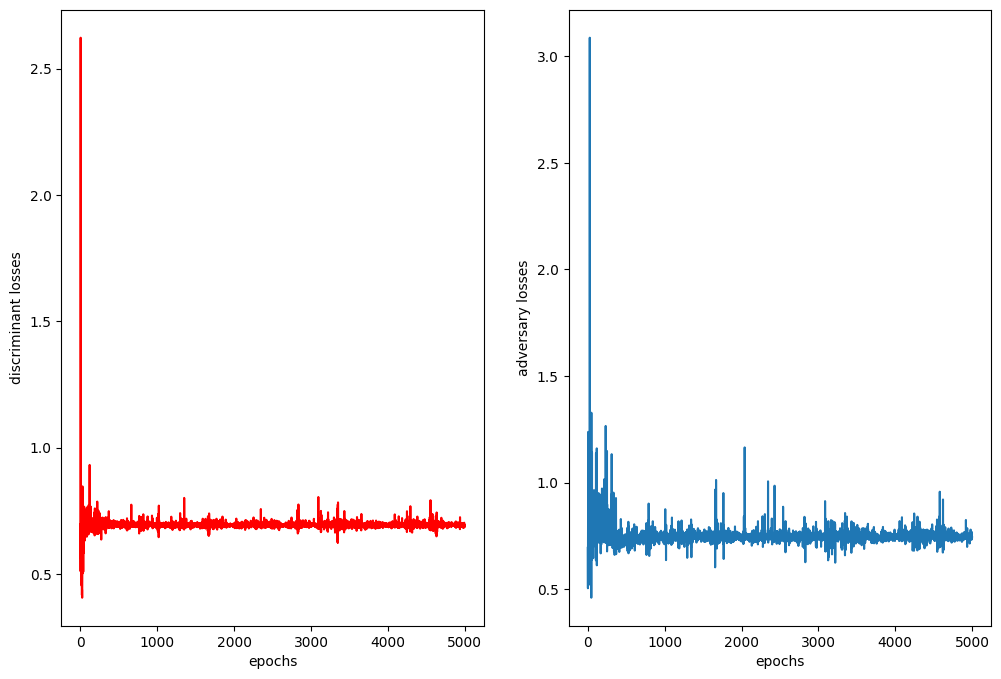

In [16]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()